# Face Verification

La tâche de *face verification* (ou vérification faciale) consiste à vérifier l'identité d'une personne à partir d'une photo "exemple". On peut imaginer une base de données contenant des une photo de chaque employé d'une entreprise. Lorsque quelqu'un se présente à la porte du batiment avec son badge, on va vérifier son identité en comparant la photo de la personne à la porte à la photo stockée en base de données. 

Comme vous devez l'imaginer, cette tâche présente plusieurs contraintes : 
- Tout d'abord, on n'a pas forcément accès à des centaines de photos de chaque personne de l'entreprise pour l'entrainement.
- Ensuite, on voudrait éviter de ré-entraîner le modèle dès qu'une nouvelle personne rejoint l'entreprise. 

Pour ce problème, nous allons suivre la méthode introduite dans le papier [Learning a Similarity Metric Discriminatively, with Application to Face Verification](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=1467314) qui propose d'entraîner une mesure de similarité à partir des données. 

Cette méthode est très performante pour des datasets qui contiennent un nombre très importants de catégories (pour les visages, chaque personne est une catégorie) et/ou dans les cas où l'on ne dispose pas de toutes les catégories lors de l'entraînement du modèle (nouvelle personne qui rejoint l'entreprise).

Commençons par analyser quelques points théoriques de l'article pour comprendre le fonctionnement de la méthode puis nous passerons à la partie implémentation. 

## Analyse théorique de l'article

### Intuition

L'idée principale de l'article est d'entraîner le modèle de manière contrastive sur des paires d'images.   
Pour les paires d'images, deux scénarios sont possibles, soit les deux images proviennent de la même catégorie, soit elles proviennent d'une catégorie différente.  

Ce qu'on veut, c'est avoir un modèle $G_w$ qui va mapper une image dans un espace latent où la distance euclidienne (ou cosinus) permettent de différencier efficacement les éléments.  

Plus formellement, on vaut avoir :   
$D_W(X_1,X_2) = \lVert G_W(X_1) - G_W(X_2)\rVert $  petit si $X_1$ et $X_2$ sont dans la même catégorie et grand si ils sont dans des catégories différentes.

Le modèle est entraîné sur des paires d'images et les poids de $G_W$ sont bien entendu partagés.   
L'architecture ressemble à cela :  

<img src="images/siamese.png" alt="siamese" width="400"/>

Figure extraite de l'article original (le $E_W$ de la figure correspond à notre $D_W$)

Ou (de manière plus simple) à cela : 

<img src="images/siamese2.png" alt="siamese2" width="500"/>

### Loss contrastif

Mais alors, comment est ce que l'on peut définir notre fonction de *loss* pour cet objectif ?   
Prenons $Y$ le label de notre paire d'image. Si $Y$ vaut 0 alors les images proviennent de la même catégorie, sinon $Y$ vaut 1.  
La fonction de *loss* contrastif s'exprime alors de la manière suivante :  
$L(Y,X_1,X_2)= (1-Y)\frac{1}{2}(D_W)^2 + (Y)\frac{1}{2}(max(0,m-D_W))²$

La fonction de *loss* fait un peu peur vue comme ça mais elle est en fait assez simple.  
Regardons pour les deux valeurs possibles de $Y$ : 
- Si $Y = 0$, alors  $L(Y,X_1,X_2)= \frac{1}{2}(D_W)^2$ ce qui correspond simplement à la distance $D_W$ que l'on a définit plus haut.  
- Si $Y = 1$, alors $L(Y,X_1,X_2)= \frac{1}{2}(max(0,m-D_W))²$. Cette partie demande un peu plus d'explication. On pourrait supposer que simplement utiliser $\frac{1}{D_W}$ permettrait de maximiser la distance (ce que l'on veut). En pratique, cela ne fonctionne pas car le modèle pourrait apprendre à séparer les éléments d'une marge très petite ce qui pourrait poser des problèmes de généralisation. Le paramètre $m$ (margin) permet de spécifier une marge minimale de séparation entre les éléments différents. Cela rend le modèle plus robuste et stabilise l'entraînement. 

**Note** : Pourquoi ne pas simplement minimiser $D_W(X_1,X_2)$ sur des paires d'images de la même catégorie uniquement ? Si on fait cela, le modèle peut *collapse* et apprendre un solution triviale qui consiste à faire de $G_W$ une fonction constante si bien que le *loss* sera toujours égal à 0. A noter qu'en pratique, le modèle va toujours aller au plus simple, il faut donc veiller à bien définir ses fonctions de *loss* pour éviter que le modèle trouve un raccourci trivial.

### Architecture du modèle et entraînement

$G_W$ peut être n'importe quel réseau de neurones. L'article propose d'utiliser un réseau convolutifs pour ses capacités sur les images et sa robustesse aux distorsions géométriques (qui sont courantes pour la face verification). 

Nous n'allons pas reproduire strictement l'architecture de l'article mais nous allons plutôt concevoir notre propre architecture et l'entraîner sur un dataset plus conséquent que ceux de l'article. 

Pour l'entraînement, l'article préconise d'utiliser 50% de paires positives et 50% de paires négatives.

## Implémentation 

In [15]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Il est temps d'implémenter notre modèle ! 

### Dataset

Comme dataset, nous utilisons [LFW](https://vis-www.cs.umass.edu/lfw/) qui regroupe 13233 images de 5749 personnes avec 1680 ayant au moins 2 images (nécessaire pour les exemples positifs). Nous utilisons la [LFWPairs](https://pytorch.org/vision/main/generated/torchvision.datasets.LFWPairs.html) de torchvision qui regroupe déjà les images par paires positives ou négatives en proportion égales.  

In [100]:
transform = T.Compose([
    T.ToTensor(),
    T.Resize((128,128)), # On réduit la taille des images pour accélérer l'entraînement
])
train_data=datasets.LFWPairs(root='./../data',download=False,split= 'train',transform=transform)
test_data=datasets.LFWPairs(root='./../data',download=False,split= 'test',transform=transform)

Nombre de paires pour le training:  2200
Nombre de paires pour le test: 1000
Taille image torch.Size([3, 128, 128])


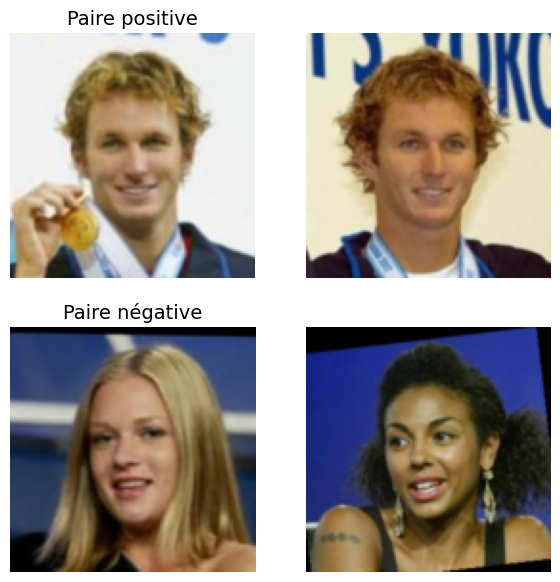

In [101]:
print('Nombre de paires pour le training: ',len(train_data))
print('Nombre de paires pour le test:',len(test_data))
print('Taille image',train_data[0][0].shape)

fig, axs = plt.subplots(2, 2, figsize=(7, 7))

axs[0, 0].imshow(train_data[0][0].permute(1, 2, 0))
axs[0, 0].axis('off')

axs[0, 1].imshow(train_data[0][1].permute(1, 2, 0))
axs[0, 1].axis('off')
for data in train_data:
  if data[2]==0:
    axs[1, 0].imshow(data[0].permute(1,2,0))
    axs[1, 0].axis('off')
    axs[1, 1].imshow(data[1].permute(1,2,0))
    axs[1, 1].axis('off')
    break
axs[0, 0].set_title("Paire positive", fontsize=14, ha='center')
axs[1, 0].set_title("Paire négative", fontsize=14, ha='center');


On remarque que dans le dataset, $Y=1$ correspond à une paire positive tandis que $Y=0$ correspond à une paire négative. C'est l'inverse des notations de l'article. On va inverser ça pour plus de clarté.

In [102]:
# On ne peut pas modifier les données directement, on doit les transformer en listes
# Pour les données de training
train_data_list = [list(data) for data in train_data]
for data in train_data_list:
    data[2] = 1 - data[2]
train_data = [tuple(data) for data in train_data_list]

# Pour les données de test
test_data_list = [list(data) for data in test_data]
for data in test_data_list:
    data[2] = 1 - data[2]
test_data = [tuple(data) for data in test_data_list]

On va maintenant pouvoir créer nos dataloaders : 

In [103]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

### Fonction de loss contrastif

Il est temps de définir notre fonction de *loss*. Pour cela, on va simplement reprendre la formule que l'on a introduite plus haut. Pour $D_W$ on prend la distance euclidienne :   
$D_W (X_1,X_2) = \lVert X_1 - X_2 \rVert_2 = \sqrt{\sum_{i=1}^{n} (X_{1,i} - X_{2,i})^2}$

In [104]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Distance euclidienne entre les deux sorties du réseau
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        
        # Calcul du loss contrastif
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2) +
            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )
        
        return loss_contrastive

### Création de notre modèle

Pour cette tâche nous allons construire un réseau convolutif classique et assez petit. Le but du modèle est de projetter les données dans un espace où la distance euclidienne est une distance pertinente. 

In [142]:
class SiameseNetwork(torch.nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Extraction des features pertinentes
        self.conv_net = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        # Projection des features dans un espace de dimension réduite
        self.linear=nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 32), 
            )
    
    def forward(self, x1, x2):
        x1 = self.conv_net(x1)
        x2 = self.conv_net(x2)
        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)
        x1=self.linear(x1)
        x2=self.linear(x2)
        return x1,x2

### Entrainement du modèle

Définissons nos hyperparamètres d'entrainement : 

In [134]:
epochs = 30
lr = 0.001
margin = 1.0
model = SiameseNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion=ContrastiveLoss(margin=margin)

In [135]:
for epoch in range(epochs):
  loss_train = 0
  for x1, x2, label in train_loader:
    x1, x2, label = x1.to(device), x2.to(device), label.to(device)
    optimizer.zero_grad()
    out1, out2 = model(x1, x2)
    loss = criterion(out1, out2, label)
    loss_train+=loss.item()
    loss.backward()
    optimizer.step()
  print(f"Epoch {epoch+1}/{epochs} Loss: {loss_train/len(train_loader)}")

Epoch 1/30 Loss: 0.4855058027998261
Epoch 2/30 Loss: 0.47506297098985617
Epoch 3/30 Loss: 0.44379603841166565
Epoch 4/30 Loss: 0.36472982092612033
Epoch 5/30 Loss: 0.31656959955243097
Epoch 6/30 Loss: 0.3091158025722573
Epoch 7/30 Loss: 0.2988005231903947
Epoch 8/30 Loss: 0.2873344306928524
Epoch 9/30 Loss: 0.28030256138763565
Epoch 10/30 Loss: 0.27428370077108993
Epoch 11/30 Loss: 0.27216234900381253
Epoch 12/30 Loss: 0.2714559338662935
Epoch 13/30 Loss: 0.2713507852260617
Epoch 14/30 Loss: 0.27069854628348694
Epoch 15/30 Loss: 0.26960040553324466
Epoch 16/30 Loss: 0.26909896256267163
Epoch 17/30 Loss: 0.2681442526155624
Epoch 18/30 Loss: 0.26780268636302673
Epoch 19/30 Loss: 0.2663887916267782
Epoch 20/30 Loss: 0.26515361407528754
Epoch 21/30 Loss: 0.26577359880658163
Epoch 22/30 Loss: 0.266544328543587
Epoch 23/30 Loss: 0.2644324919235879
Epoch 24/30 Loss: 0.26508791971465817
Epoch 25/30 Loss: 0.26529018699690915
Epoch 26/30 Loss: 0.26407808313767117
Epoch 27/30 Loss: 0.264637937796

### Evaluation du modèle

Maintenant que l'entraînement est terminé, il faut évaluer le modèle. Mais alors comment faire ? Ce n'est pas le type de modèle que nous avons l'habitude d'évaluer.  

On a notre dataset de test et on peut calculer les distances entre chaque paire de ce dataset. Donc dans l'idée, on peut avoir un score de similarité pour chaque élément du dataset de test.   

**La courbe ROC** : La courbe ROC (*Receiver Operating Characteristic*) est un graphique qui illustre les performances d'un modèle de classification binaire (pour nous, positif ou négatif) à différents seuils de décision. La courbe ROC contient les éléments suivants : 
- **Axe des X** est de le taux de faux positifs (ou taux de fausse alarme). C'est le nombre d'éléments négatifs incorrectement classés comme positifs, divisé par le nombre total d'éléments négatifs.
- **Axe des Y** est le taux de vrais positifs (rappel ou sensibilité). C'est le nombre d'éléments positifs correctement classés comme positifs, divisé par le nombre total d'éléments positifs.

Chaque point de la courbe va représenter un seuil de décision différent pour la classification des éléments. 

<img src="images/roc.png" alt="roc" width="500"/>

Figure extraite de [blogpost](https://sefiks.com/2020/12/10/a-gentle-introduction-to-roc-curve-and-auc/).

Pour juger la qualité d'un modèle, on peut calculer l'aire sous la courbe ROC (AUROC). Dans le cas du *random classifier* on aura un AUROC de 0.5 alors que si il s'agit du classifieur parfait, l'AUROC sera de 1.

On peut le calculer pour notre modèle :

In [139]:
from sklearn.metrics import roc_curve, auc

model.eval()
labels = []
distances = []
with torch.no_grad():
    for x1, x2, label in test_loader:
        x1, x2, label = x1.to(device), x2.to(device), label.to(device)
        out1, out2 = model(x1, x2)
        dist = torch.nn.functional.pairwise_distance(out1, out2)
        distances.extend(dist.cpu().numpy())
        labels.extend(label.cpu().numpy())
        
fpr, tpr, thresholds = roc_curve(labels, distances)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc}")


ROC AUC: 0.6163399999999999


On obtient un AUROC de 0.62 environ ce qui n'est vraiment pas terrible. On peut aussi tracer la courbe pour voir de quoi ça a l'air.

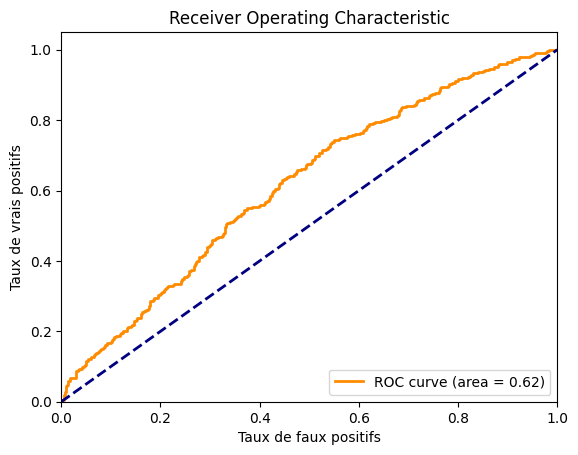

In [141]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

On constate que le modèle n'est pas très performant. Le dataset est sans doute trop complexe par rapport à la taille de notre modèle. Vous pouvez essayer d'améliorer les performances du modèles en jouant sur l'architecture et les paramètres d'entrainement.  

## Triplet loss

### Face recognition

Dans le domaine du traitement des visages, on a deux catégories principales : *face verification* et *face recognition*.   
Pour comprendre la nuance entre les deux, reprenons le cas de notre employé d'entreprise : 
- **Face verification** : Dans le cas de la *face verification*, un employé va vouloir entrer dans le batiment avec son badge. Il passe son badge dans la machine et le modèle de *face verification* va vérifier qu'il s'agit bien de l'employé possédant ce badge.  
- **Face recognition** : Ici, il faut plutôt imaginer que l'employé se rend au batiment sans son badge et que le modèle est capable de le reconnaître parmi la base de données de tous les employés pour le laisser entrer dans la batiment.

Comme vous pouvez l'imaginer, la seconde tâche est plus complexe que ce soit en terme de difficulté pure ou même en terme de contraintes de temps de traitement (on ne va pas faire attendre l'employé à la porte pendant 1 heure le temps de comparer sa photo aux centaines de photos de notre base de données).

### FaceNet

Pour la tâche de *face recognition*, un article [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/pdf/1503.03832) a introduit un nouveau type de loss qui ressemble au *loss* contrastif. Il s'agit du Triplet Loss que nous allons décrire brièvement. 

L'objectif de ce loss est similaire à celui du *loss* contrastif : il vise à apprendre une représentation de sorte que les vecteurs de caractéristiques (ou *embeddings*) de points similaires soient rapprochés dans l'espace latent, tandis que ceux de points différents soient éloignés les uns des autres.

Contrairement au *loss* contrastif qui se base sur des paires d'exemples. Le *triplet loss* se base sur des ** roulements de tambours ** triplets d'exemples !

Chaque exemple a son rôle particulier : 
- **Anchor (A)** : L'exemple de référence dont on cherche à apprendre une représentation
- **Positive(P)** : Un exemple similaire à l'*anchor* (même personne par exemple)
- **Negative(N)** : Un exemple différent de l'*anchor* (une personne différente)

La fonction du *loss* est définie comme :  
$L_{\text{triplet}} = \max\left( d(A, P) - d(A, N) + \alpha, 0 \right)$ où $d$ est la distance et $\alpha$ la marge (*margin*). 

Ce loss minimise la distance entre $P$ et $A$ tout en maximisant celle entre $N$ et $A$. 

<img src="images/tripletloss.png" alt="roc" width="600"/>

Figure extraite de l'article original.

Cela peut sembler redondant avec le *loss* contrastif et c'est un peu le cas. Cependant, le *triplet loss* a demontré des meilleurs résultats lorsqu'il s'agit de faire une distinction fine entre des classes assez similaire (typiquement le cas de la reconnaissance faciale). Aujourd'hui, son utilisation est préférée à celle du loss contrastif pour les tâches de traitement des visages.